<a href="https://colab.research.google.com/github/alilotfi90/Flower_Classification/blob/main/Copy-of-flower-classification-data_augmentation-normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

!pip install efficientnet_pytorch
from zipfile import ZipFile
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
import zipfile
from PIL import Image
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:



with zipfile.ZipFile('/content/drive/MyDrive/flowerimages.zip', 'r') as zip_ref:
    zip_ref.extractall('unzipped_images_flower')

In [6]:
!pip install Pillow
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:


unzipped_folder = '/content/unzipped_images_flower/flowers'
output_folder = '/content/resized_images_flower'


os.makedirs(output_folder, exist_ok=True)

subdirectories = [d for d in os.listdir(unzipped_folder) if os.path.isdir(os.path.join(unzipped_folder, d))]

# seen = set()
for flower_category in subdirectories:
    input_folder = os.path.join(unzipped_folder, flower_category)
    output_category_folder = os.path.join(output_folder, flower_category)


    os.makedirs(output_category_folder, exist_ok=True)

    image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]

    for image_file in image_files:
        input_image_path = os.path.join(input_folder, image_file)
        output_image_path = os.path.join(output_category_folder, image_file)

        image = Image.open(input_image_path)

        # # Resize the image
        # target_size = (456, 456)
        # image = image.resize(target_size, Image.ANTIALIAS)

        # Convert the image to grayscale
        image = image.convert('L')


        image.save(output_image_path)

        # width, height = image.size
        # # seen.add((width, height))

In [8]:
# max_images_per_class =200

# Transformation 1, Resize, Grayscale, normalize
data = []

for flower_category in subdirectories:
    category_folder = os.path.join(output_folder, flower_category)
    image_files = [f for f in os.listdir(category_folder) if f.endswith('.jpg')]
    label = subdirectories.index(flower_category)  # Assign a label based on the folder name

    # # Limit the number of images to max_images_per_class
    # image_files = image_files[:max_images_per_class]

    for image_file in image_files:
        image_path = os.path.join(category_folder, image_file)
        data.append((image_path, label))

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


# Splitting train_data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 381MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch 1/5
Training Loss: 0.734, Accuracy: 77.83%
Validation Loss: 0.739, Accuracy: 80.98%
Epoch 2/5
Training Loss: 0.703, Accuracy: 78.91%
Validation Loss: 0.703, Accuracy: 79.83%
Epoch 3/5
Training Loss: 0.390, Accuracy: 87.92%
Validation Loss: 0.539, Accuracy: 85.23%
Epoch 4/5
Training Loss: 0.297, Accuracy: 90.63%
Validation Loss: 0.751, Accuracy: 80.39%
Epoch 5/5
Training Loss: 0.219, Accuracy: 93.16%
Validation Loss: 0.583, Accuracy: 83.60%
Epoch 1/10
Training Loss: 0.160, Accuracy: 95.14%
Validation Loss: 0.420, Accuracy: 88.77%
Epoch 2/10
Training Loss: 0.290, Accuracy: 91.17%
Validation Loss: 0.520, Accuracy: 84.84%
Epoch 3/10
Training Loss: 0.198, Accuracy: 94.14%
Validation Loss: 0.652, Accuracy: 84.64%
Epoch 4/10
Training Loss: 0.198, Accuracy: 93.79%
Validation Loss: 0.468, Accuracy: 86.74%
Epoch 5/10
Training Loss: 0.262, Accuracy: 92.58%
Validation Loss: 0.685, Accuracy: 81.34%
Epoch 6/10
Training Loss: 0.205, Accuracy: 93.88%

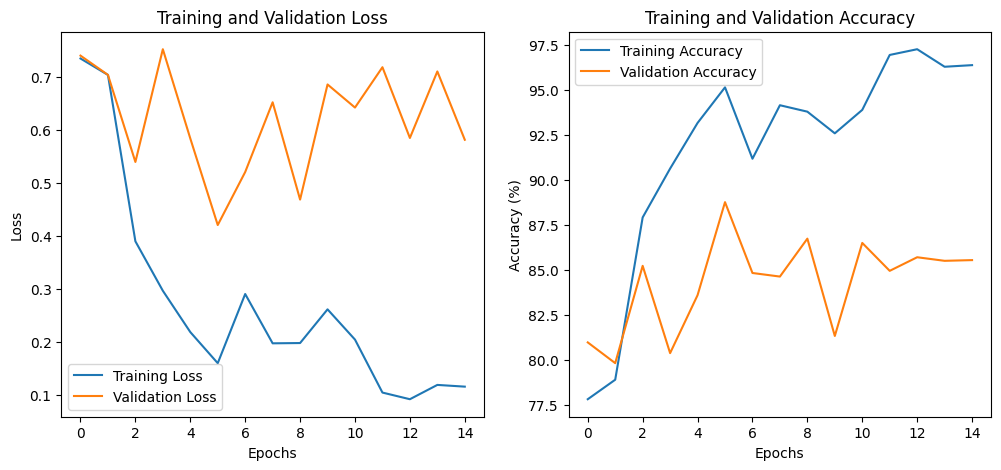

In [9]:
from sklearn.metrics import accuracy_score

transform_1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label



# Creating datasets for training, validation, and testing
train_dataset = CustomDataset(train_data, transform=transform_1)
val_dataset = CustomDataset(val_data, transform=transform_1)
test_dataset = CustomDataset(test_data, transform=transform_1)

# Creating data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



# model, criterion, optimizer
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=16)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

max_epoch = [5, 10]
for e in max_epoch:
    model.train()
    for epoch in range(e):
        print(f"Epoch {epoch + 1}/{e}")
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        print(f'Training Loss: {avg_train_loss:.3f}, Accuracy: {train_accuracy:.2f}%')

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Validation Loss: {avg_val_loss:.3f}, Accuracy: {val_accuracy:.2f}%')


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

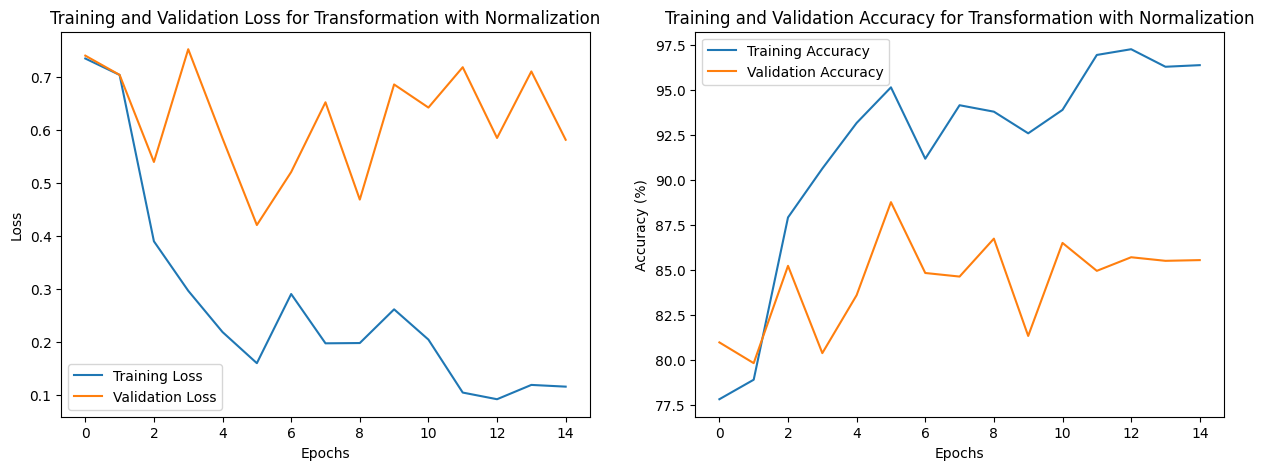

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss for Transformation with Normalization')  # Corrected title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Transformation with Normalization')  # Appropriate title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

save_path = '/content/drive/MyDrive/effnet_normalization_plot.jpg'

plt.savefig(save_path)

plt.show()



In [11]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {avg_test_loss:.3f}, Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.526, Accuracy: 85.90%
